**Research Methods, Spring 2025**

**Author**: Pablo Estrada

The answers to the homework questions using `Python` are described below. Note that I follow closely the analysis from professor McCarthy and his `R` script. My analysis file is also available in the analysis folder.

In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import warnings
warnings.simplefilter('ignore')

# To run in the terminal:
# python data-code/_HCRIS_Data.py

# Matplotlib settings
%config InlineBackend.figure_format = 'retina'
blue = '#002878'
gold = '#d2b000'
plt.rcParams.update({
    "text.usetex": True,
    # "font.family": "Helvetica"
})

In [3]:
# Read data
hcris_data_v1996 = pd.read_csv('data/output/HCRIS_v1996.csv')
hcris_data_v2010 = pd.read_csv('data/output/HCRIS_v2010.csv')
hcris_data = pd.read_csv('data/output/HCRIS_Data.csv')

# Filter data for the years 2008-2015
hcris_data = hcris_data[(hcris_data['year'] >= 2008) & (hcris_data['year'] <= 2015)]

# Create summary objects
version_1996 = hcris_data_v1996.groupby('year').size().reset_index(name='count_1996')
version_2010 = hcris_data_v2010.groupby('year').size().reset_index(name='count_2010')

# Merge datasets
version_data = pd.merge(version_1996, version_2010, on='year', how='outer')

# Add missing columns in v1996 dataset
hcris_data_v1996['hvbp_payment'] = np.nan
hcris_data_v1996['hrrp_payment'] = np.nan

# Combine v1996 and v2010 datasets
final_hcris = pd.concat([hcris_data_v1996, hcris_data_v2010], ignore_index=True)

# Convert date columns to datetime format
date_cols = ['fy_end', 'fy_start', 'date_processed', 'date_created']
for col in date_cols:
    final_hcris[col] = pd.to_datetime(final_hcris[col], errors='coerce')

# Apply transformations
final_hcris['tot_discounts'] = final_hcris['tot_discounts'].abs()
final_hcris['hrrp_payment'] = final_hcris['hrrp_payment'].abs()
final_hcris['fyear'] = final_hcris['fy_end'].dt.year

# Sort and filter
final_hcris = final_hcris.sort_values(by=['provider_number', 'fyear'])
final_hcris = final_hcris[(final_hcris['fyear'] >= 2008) & (final_hcris['fyear'] <= 2015)]

\newpage

**1. How many hospitals filed more than one report in the same year?** 

Show your answer as a line graph of the number of hospitals over time.

In [4]:
# Count distinct providers
num_providers = hcris_data['provider_number'].nunique()
print(f'Number of distinct providers: {num_providers}')

# Count duplicate reports per provider per year
dup_count = final_hcris.groupby(['provider_number', 'fyear']).size().reset_index(name='total_reports')
dup_count['dup_report'] = dup_count['total_reports'] > 1

# Summarize duplicates per year
dup_summary = dup_count.groupby('fyear')['dup_report'].sum().reset_index()

Number of distinct providers: 6746


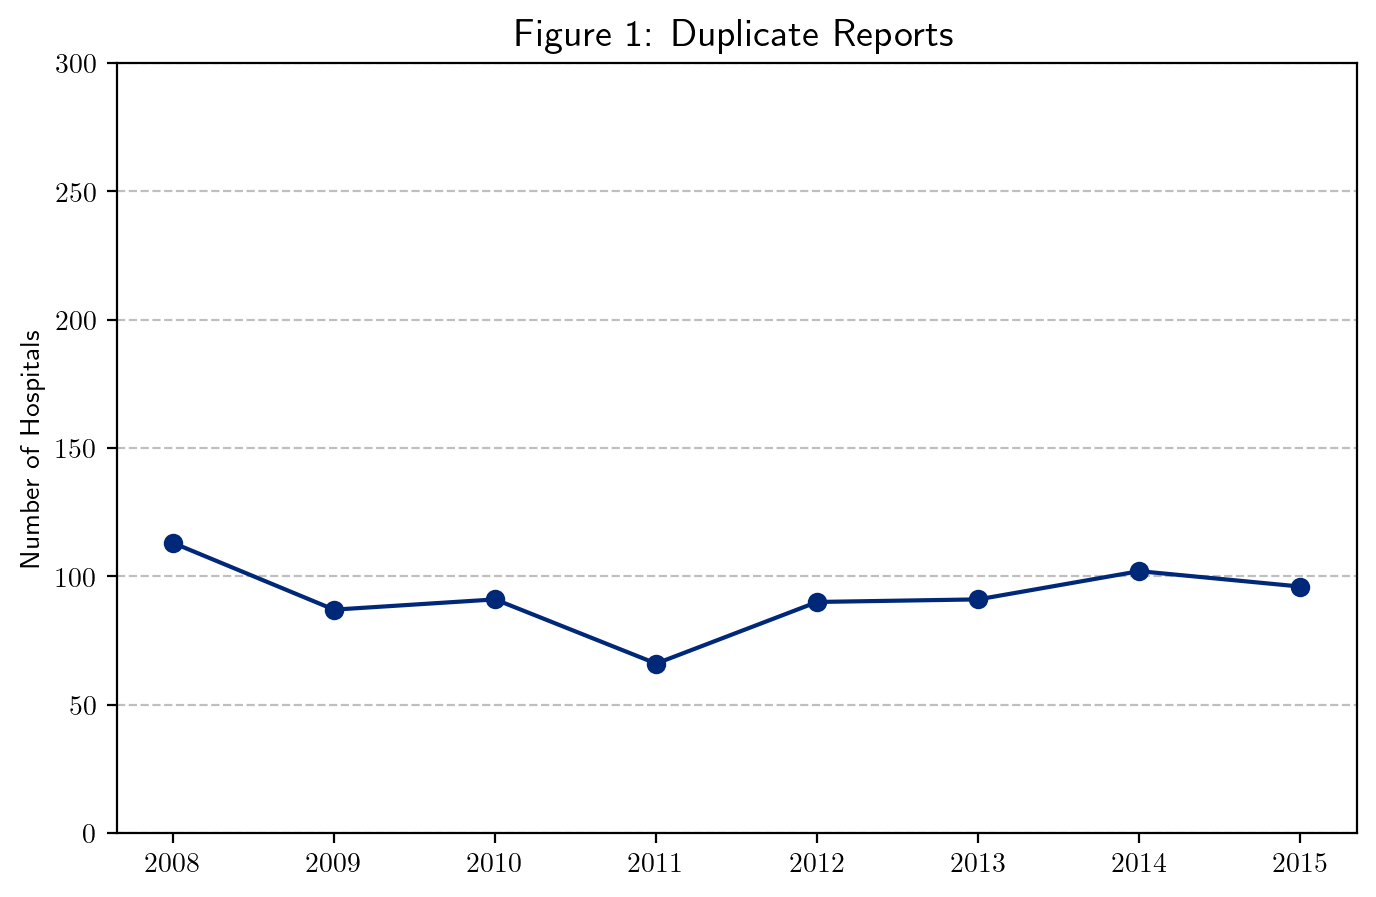

In [5]:
# Plot duplicate reports per year
plt.figure(figsize=(8, 5))
plt.plot(dup_summary['fyear'].values, dup_summary['dup_report'].values, 
         marker='o', linestyle='-', color=blue)

# Format plot
plt.title('Figure 1: Duplicate Reports', fontsize=14)
plt.xlabel('')
plt.ylabel('Number of Hospitals')
plt.ylim(0, 300)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

\newpage

**2. After removing/combining multiple reports, how many unique hospital IDs (Medicare provider numbers) exist in the data?**

In [6]:
# Count unique hospitals per year
hosp_count = hcris_data.groupby('year').size().reset_index(name='hosp_count')

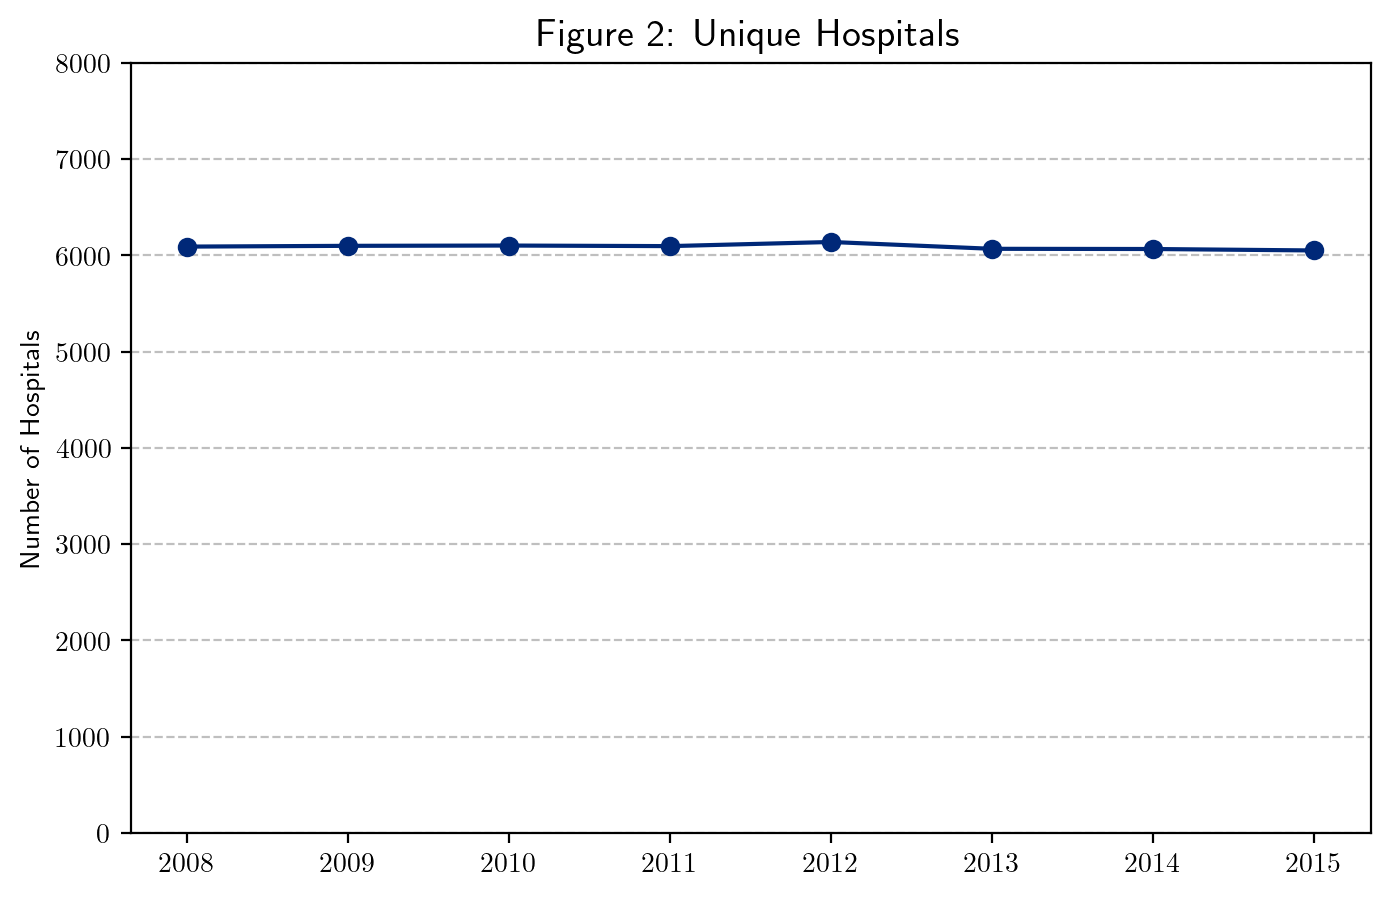

In [7]:
# Plot unique hospitals per year
plt.figure(figsize=(8, 5))
plt.plot(hosp_count['year'].values, hosp_count['hosp_count'].values, 
         marker='o', linestyle='-', color=blue)

# Format plot
plt.title('Figure 2: Unique Hospitals', fontsize=14)
plt.xlabel('')
plt.ylabel('Number of Hospitals')
plt.ylim(0, 8000)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

\newpage

**3. What is the distribution of total charges (tot_charges in the data) in each year?**

 Show your results with a “violin” plot, with charges on the y-axis and years on the x-axis.

In [8]:
# Filter and preprocess data
charge_data = hcris_data.copy()

# Compute 1st and 99th percentiles for total charges per year
charge_data['tot_charges_low'] = charge_data.groupby('year')['tot_charges'].transform(lambda x: np.nanpercentile(x, 1))
charge_data['tot_charges_high'] = charge_data.groupby('year')['tot_charges'].transform(lambda x: np.nanpercentile(x, 99))

# Filter out extreme values and missing data
charge_data = charge_data[
    (charge_data['tot_charges'] > charge_data['tot_charges_low']) &
    (charge_data['tot_charges'] < charge_data['tot_charges_high']) &
    charge_data['tot_charges'].notna() &
    (charge_data['year'] > 1997)
]

# Compute log of total charges
charge_data['log_charge'] = np.log(charge_data['tot_charges'])

# Preparing data for violin plot
years = sorted(charge_data['year'].unique())
data = [charge_data[charge_data['year'] == y]['log_charge'].dropna().values for y in years]

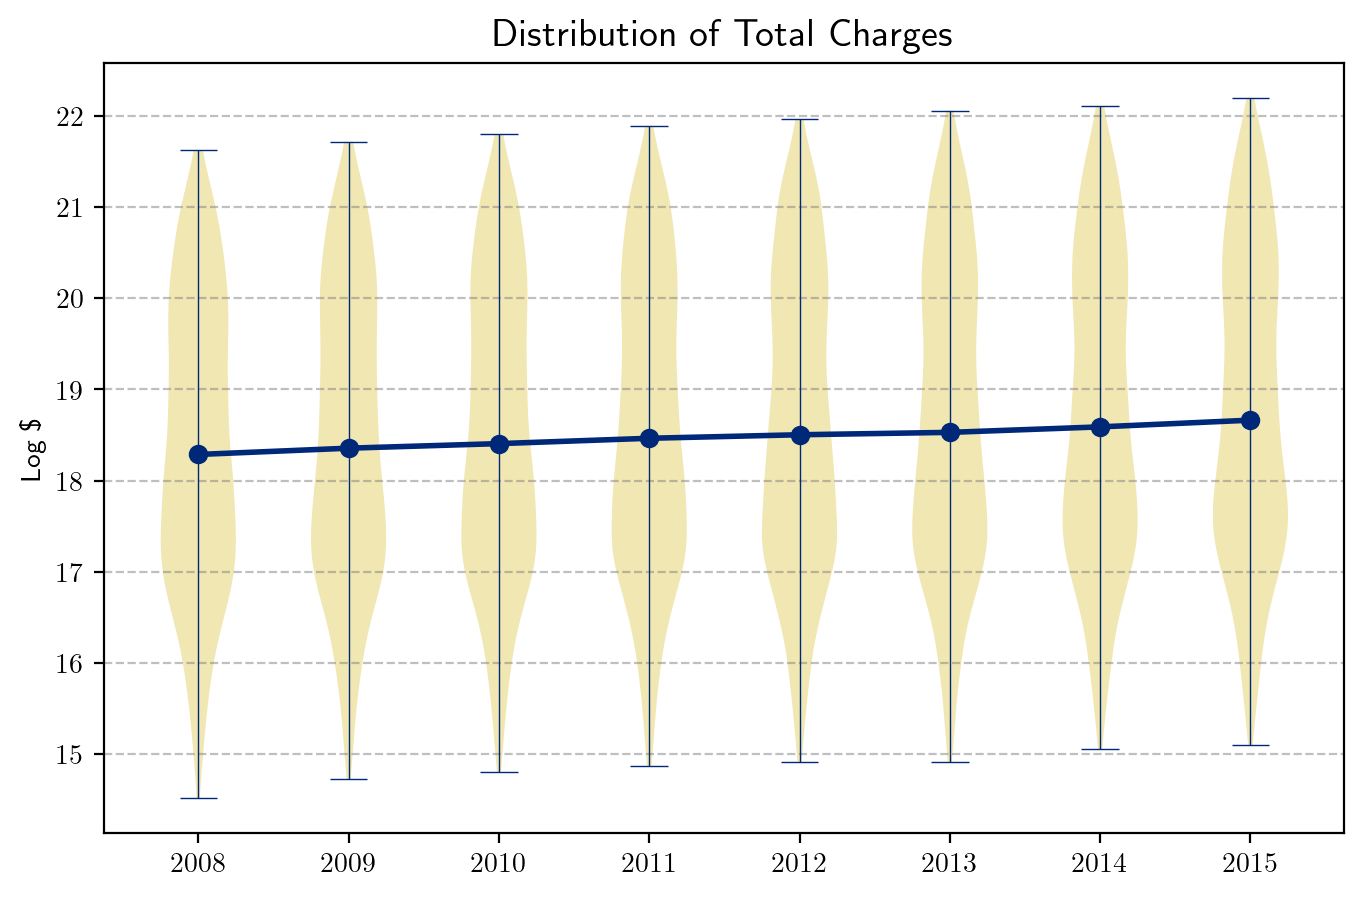

In [9]:
# Plot distribution of total charges
fig, ax = plt.subplots(figsize=(8, 5))
parts = ax.violinplot(data, positions=years, showmedians=False)

# Customize violin plot appearance
for pc in parts['bodies']:
    pc.set_facecolor(gold)
    pc.set_alpha(0.3)

for part in ['cbars', 'cmins', 'cmaxes']:
    parts[part].set_color(blue)
    parts[part].set_linewidth(0.5)

# Add median line
median = charge_data.groupby('year')['log_charge'].median()
plt.plot(years, median.values, marker='o', linestyle='-', color=blue, linewidth=2)

# Format plot
plt.title('Distribution of Total Charges', fontsize=14)
plt.xlabel('')
plt.ylabel('Log \$')
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

\newpage

**4. What is the distribution of estimated prices in each year?**

Again present your results with a violin plot, and recall our formula for estimating prices from class. Be sure to do something about outliers and/or negative prices in the data.

In [10]:
# Compute price data
hcris_data['discount_factor'] = 1 - hcris_data['tot_discounts'] / hcris_data['tot_charges']
hcris_data['price_num'] = (
    (hcris_data['ip_charges'] + hcris_data['icu_charges'] + hcris_data['ancillary_charges']) * 
    hcris_data['discount_factor']
) - hcris_data['tot_mcare_payment']
hcris_data['price_denom'] = hcris_data['tot_discharges'] - hcris_data['mcare_discharges']
hcris_data['price'] = hcris_data['price_num'] / hcris_data['price_denom']

# Filtering the data
price_data = hcris_data[
    (hcris_data['price_denom'] > 100) & 
    (~hcris_data['price_denom'].isna()) & 
    (hcris_data['price_num'] > 0) & 
    (~hcris_data['price_num'].isna()) & 
    (hcris_data['price'] < 100000) & 
    (hcris_data['beds'] > 30) & 
    (~hcris_data['beds'].isna())
]

# Preparing data for violin plot
years = sorted(price_data['year'].unique())
data = [price_data[price_data['year'] == year]['price'].dropna().values for year in years]

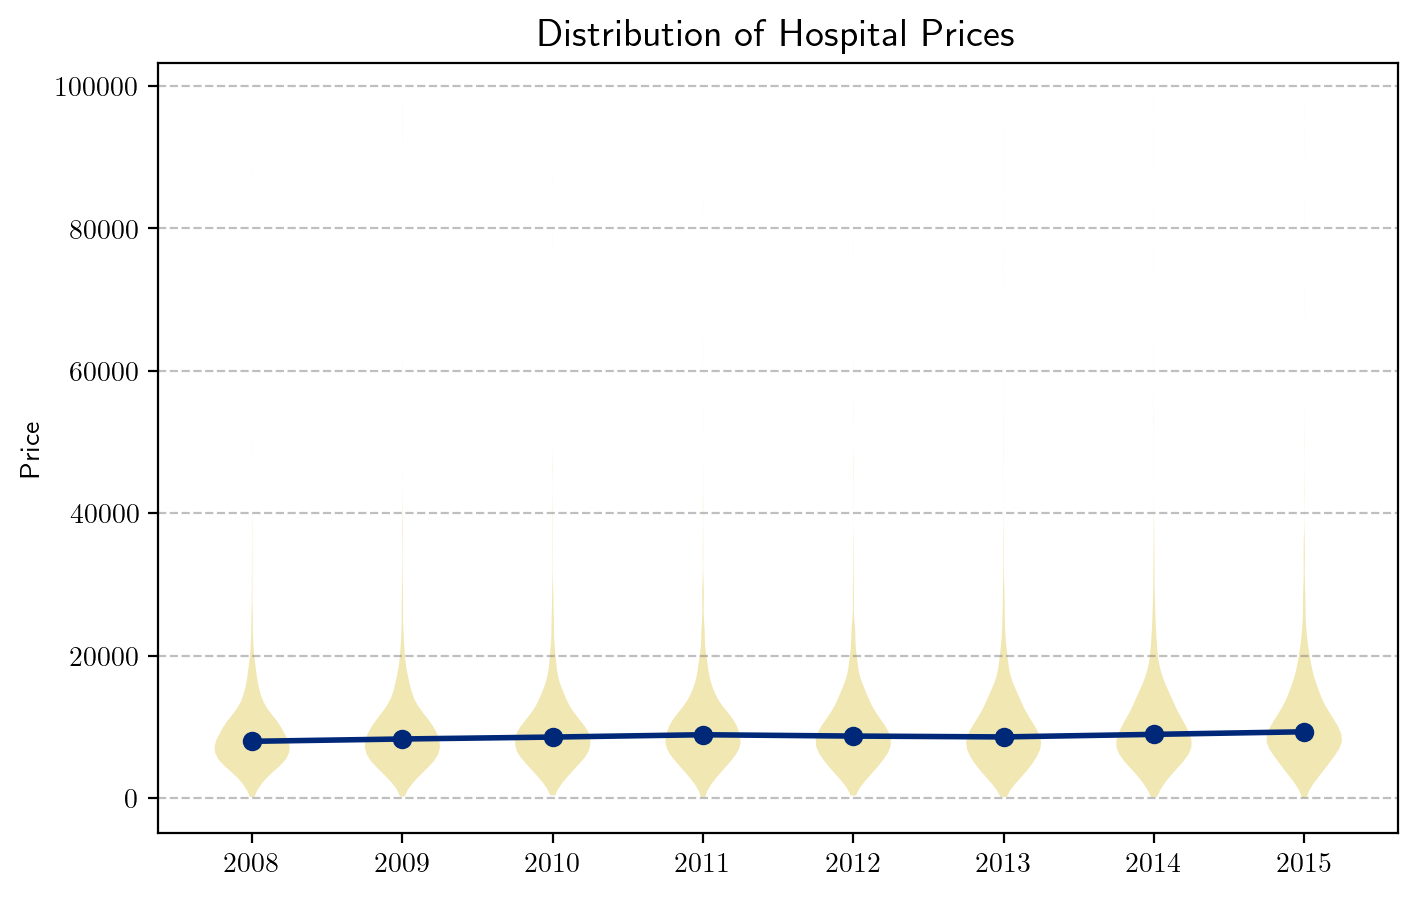

In [11]:
# Plot distribution of hospital prices
fig, ax = plt.subplots(figsize=(8, 5))
parts = ax.violinplot(data, positions=years, showmedians=False, showextrema=False)

# Customize violin plot appearance
for pc in parts['bodies']:
    pc.set_facecolor(gold)
    pc.set_alpha(0.3)

# Add median line
median = price_data.groupby('year')['price'].median()
plt.plot(years, median.values, marker='o', linestyle='-', color=blue, linewidth=2)

# Format plot
plt.title('Distribution of Hospital Prices', fontsize=14)
plt.xlabel('')
plt.ylabel('Price')
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

\newpage

For the rest of the assignment, you should include only observations in 2012. So we are now dealing with cross-sectional data in which some hospitals are penalized and some are not.

**5. Calculate the average price among penalized versus non-penalized hospitals.**

In [12]:
# Compute penalty data
price_data.loc[:, 'penalty'] = ((price_data['hvbp_payment'].fillna(0) - price_data['hrrp_payment'].fillna(0).abs()) < 0).astype(int)

# Filter data for the year 2012
pen_data_2012 = price_data[price_data['year'] == 2012].copy()

# Compute quartiles
beds_q1 = pen_data_2012['beds'].quantile(0.25)
beds_q2 = pen_data_2012['beds'].quantile(0.50)
beds_q3 = pen_data_2012['beds'].quantile(0.75)
beds_q4 = pen_data_2012['beds'].max()

# Assign bed quartiles
pen_data_2012['bed_quart'] = np.select(
    [
        pen_data_2012['beds'] < beds_q1,
        (pen_data_2012['beds'] >= beds_q1) & (pen_data_2012['beds'] < beds_q2),
        (pen_data_2012['beds'] >= beds_q2) & (pen_data_2012['beds'] < beds_q3),
        (pen_data_2012['beds'] > beds_q3) & (pen_data_2012['beds'] < beds_q4)
    ],
    [1, 2, 3, 4],
    default=0
)

# Filter out invalid quartile values
pen_data_2012 = pen_data_2012[pen_data_2012['bed_quart'] > 0]

# Compute average price by penalty status
avg_pen = pen_data_2012.groupby('penalty')['price'].mean()

# Display results
display(Markdown(f'Average price for hospitals with penalty: {avg_pen[1]:,.2f} and without penalty: {avg_pen[0]:,.2f}'))

Average price for hospitals with penalty: 9,872.96 and without penalty: 9,597.96

\newpage

Split hospitals into quartiles based on bed size. To do this, create 4 new indicator variables, where each variable is set to 1 if the hospital’s bed size falls into the relevant quartile.

**6. Provide a table of the average price among treated/control groups for each quartile.**

In [13]:
# Compute average price by penalty status and bed quartile
avg_pen = pen_data_2012.groupby(['penalty', 'bed_quart'])[['price']].mean().unstack(level=0)

# Change the name of the index and columns
avg_pen.columns = avg_pen.columns.droplevel()
avg_pen.columns = ['Not Penalized', 'Penalized']
avg_pen.columns.name = ''
avg_pen.index.name = 'Bed Size'

# Display the table
display(Markdown(avg_pen.to_markdown()))

|   Bed Size |   Not Penalized |   Penalized |
|-----------:|----------------:|------------:|
|          1 |         7747.6  |     8318.4  |
|          2 |         8602.05 |     8662.35 |
|          3 |         9869.17 |    10098.1  |
|          4 |        12367.9  |    12002.1  |

\newpage

**7. Find the average treatment effect using each of the following estimators, and present your results in a single table:**

- Nearest neighbor matching (1-to-1) with inverse variance distance based on quartiles of bed size
- Nearest neighbor matching (1-to-1) with Mahalanobis distance based on quartiles of bed size
- Inverse propensity weighting, where the propensity scores are based on quartiles of bed size
- Simple linear regression, adjusting for quartiles of bed size using dummy variables and appropriate interactions as discussed in class

In [14]:
from causalinference import CausalModel

cm = CausalModel(
    Y = pen_data_2012['price'].values,
    D = pen_data_2012['penalty'].values,
    X = pd.get_dummies(pen_data_2012['bed_quart']).values * 1
    # X = pen_data_2012['bed_quart'].values
)

# print(cm.summary_stats)
results = pd.DataFrame(index=['ATE', 'SE'], columns=['INV', 'MAH', 'IPW', 'OLS'])

# Matching by inverse variance
cm.est_via_matching(weights='inv', matches=1, bias_adj=True)
results.loc['ATE', 'INV'] = cm.estimates['matching']['ate']
results.loc['SE', 'INV'] = cm.estimates['matching']['ate_se']

# Matching by Mahalanobis distance
cm.est_via_matching(weights='maha', matches=1, bias_adj=True)
results.loc['ATE', 'MAH'] = cm.estimates['matching']['ate']
results.loc['SE', 'MAH'] = cm.estimates['matching']['ate_se']

# Inverse probability weighting
cm.est_propensity()
cm.est_via_weighting()
results.loc['ATE', 'IPW'] = cm.estimates['weighting']['ate']
results.loc['SE', 'IPW'] = cm.estimates['weighting']['ate_se']

# OLS Regression
cm.est_via_ols(adj=1)  # 1 for linear model, 2 for interaction model
results.loc['ATE', 'OLS'] = cm.estimates['ols']['ate']
results.loc['SE', 'OLS'] = cm.estimates['ols']['ate_se']
# print(cm.estimates)

# Display the table
results = results.astype(float).round(2)
display(Markdown(results.to_markdown()))

|     |    INV |    MAH |    IPW |    OLS |
|:----|-------:|-------:|-------:|-------:|
| ATE | 124.53 | 124.53 | 121    |  92.04 |
| SE  | 228.63 | 228.63 | 235.03 | 229.33 |

https://github.com/BiomedSciAI/causallib/blob/master/examples/matching.ipynb

https://github.com/BiomedSciAI/causallib/blob/master/examples/ipw.ipynb

In [23]:
from sklearn.linear_model import LogisticRegression
from causallib.estimation import IPW, Matching

X, a, y = pd.get_dummies(pen_data_2012['bed_quart'])*1, pen_data_2012['penalty'], pen_data_2012['price']

ipw = IPW(LogisticRegression())
ipw.fit(X, a)
potential_outcomes = ipw.estimate_population_outcome(X, a, y)
effect = ipw.estimate_effect(potential_outcomes[1], potential_outcomes[0])
effect

diff    125.934084
dtype: float64

In [28]:
match_mah = Matching(metric="mahalanobis")
match_mah.fit(X, a, y)
potential_outcomes = match_mah.estimate_population_outcome(X, a, y)
effect = match_mah.estimate_effect(potential_outcomes[1], potential_outcomes[0])
effect

diff    4026.332799
dtype: float64

In [185]:
# jupyter nbconvert --to pdf --no-input --output estrada-p-hwk2-1.pdf "Homework 2.ipynb"